In [ ]:
import pandas as pd
import xml
from plotnine import ggplot, aes, geom_line, labs, theme_classic, theme, element_text, element_line, scale_x_datetime
from collections import Counter
import sklearn
import random
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

## Data Pre-processing 

**All data can be obtained via the Stack Exchange archives at the following link: https://archive.org/download/stackexchange**

In [12]:
# Import data
comments = pd.read_xml('//Users/gianjaeger/Downloads/politics.stackexchange.com/Comments.xml')
users = pd.read_xml('//Users/gianjaeger/Downloads/politics.stackexchange.com/Users.xml')
posts = pd.read_xml('//Users/gianjaeger/Downloads/politics.stackexchange.com/Posts.xml')

In [13]:
# Turn relevant attributes in the posts dataframe into string
posts['Id'] = posts['Id'].astype(str)
posts['OwnerUserId'] = posts['OwnerUserId'].astype(str)
comments['Id'] = comments['Id'].astype(str)
comments['PostId'] = comments['PostId'].astype(str)
comments['UserId'] = comments['UserId'].astype(str)

In [14]:
# Print how many times the number "6738" appears in the Id column of the posts dataframe
print(posts['OwnerUserId'].str.contains('101').sum())
print(posts['OwnerUserId'].str.contains('3135').sum())
print(posts['OwnerUserId'].str.contains('18373').sum())

# Remove all rows that do not contain one of these three numbers in the Id column for posts
posts_relevant = posts[posts['OwnerUserId'].astype(str).str.contains(r'\b(101|3135|18373)\b', regex=True)]

235
517
2514


/var/folders/n5/_f2xjmkj39gb7s0th_6lyk9w0000gn/T/ipykernel_80823/3418770720.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  posts_relevant = posts[posts['OwnerUserId'].astype(str).str.contains(r'\b(101|3135|18373)\b', regex=True)]


In [15]:
# Print how many times the number "6738" appears in the Id column of the comments dataframe
print(comments['UserId'].str.contains('101').sum())
print(comments['UserId'].str.contains('3135').sum())
print(comments['UserId'].str.contains('18373').sum())

# Remove all rows that do not contain one of these three numbers in the Id column for comments
comments_relevant = comments[comments['UserId'].astype(str).str.contains(r'\b(101|3135|18373)\b', regex=True)]

1182
2627
6414


/var/folders/n5/_f2xjmkj39gb7s0th_6lyk9w0000gn/T/ipykernel_80823/3347344874.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  comments_relevant = comments[comments['UserId'].astype(str).str.contains(r'\b(101|3135|18373)\b', regex=True)]


/var/folders/n5/_f2xjmkj39gb7s0th_6lyk9w0000gn/T/ipykernel_80823/2889967037.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/gianjaeger/Desktop/Exam_fundamentals/final/lib/python3.12/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


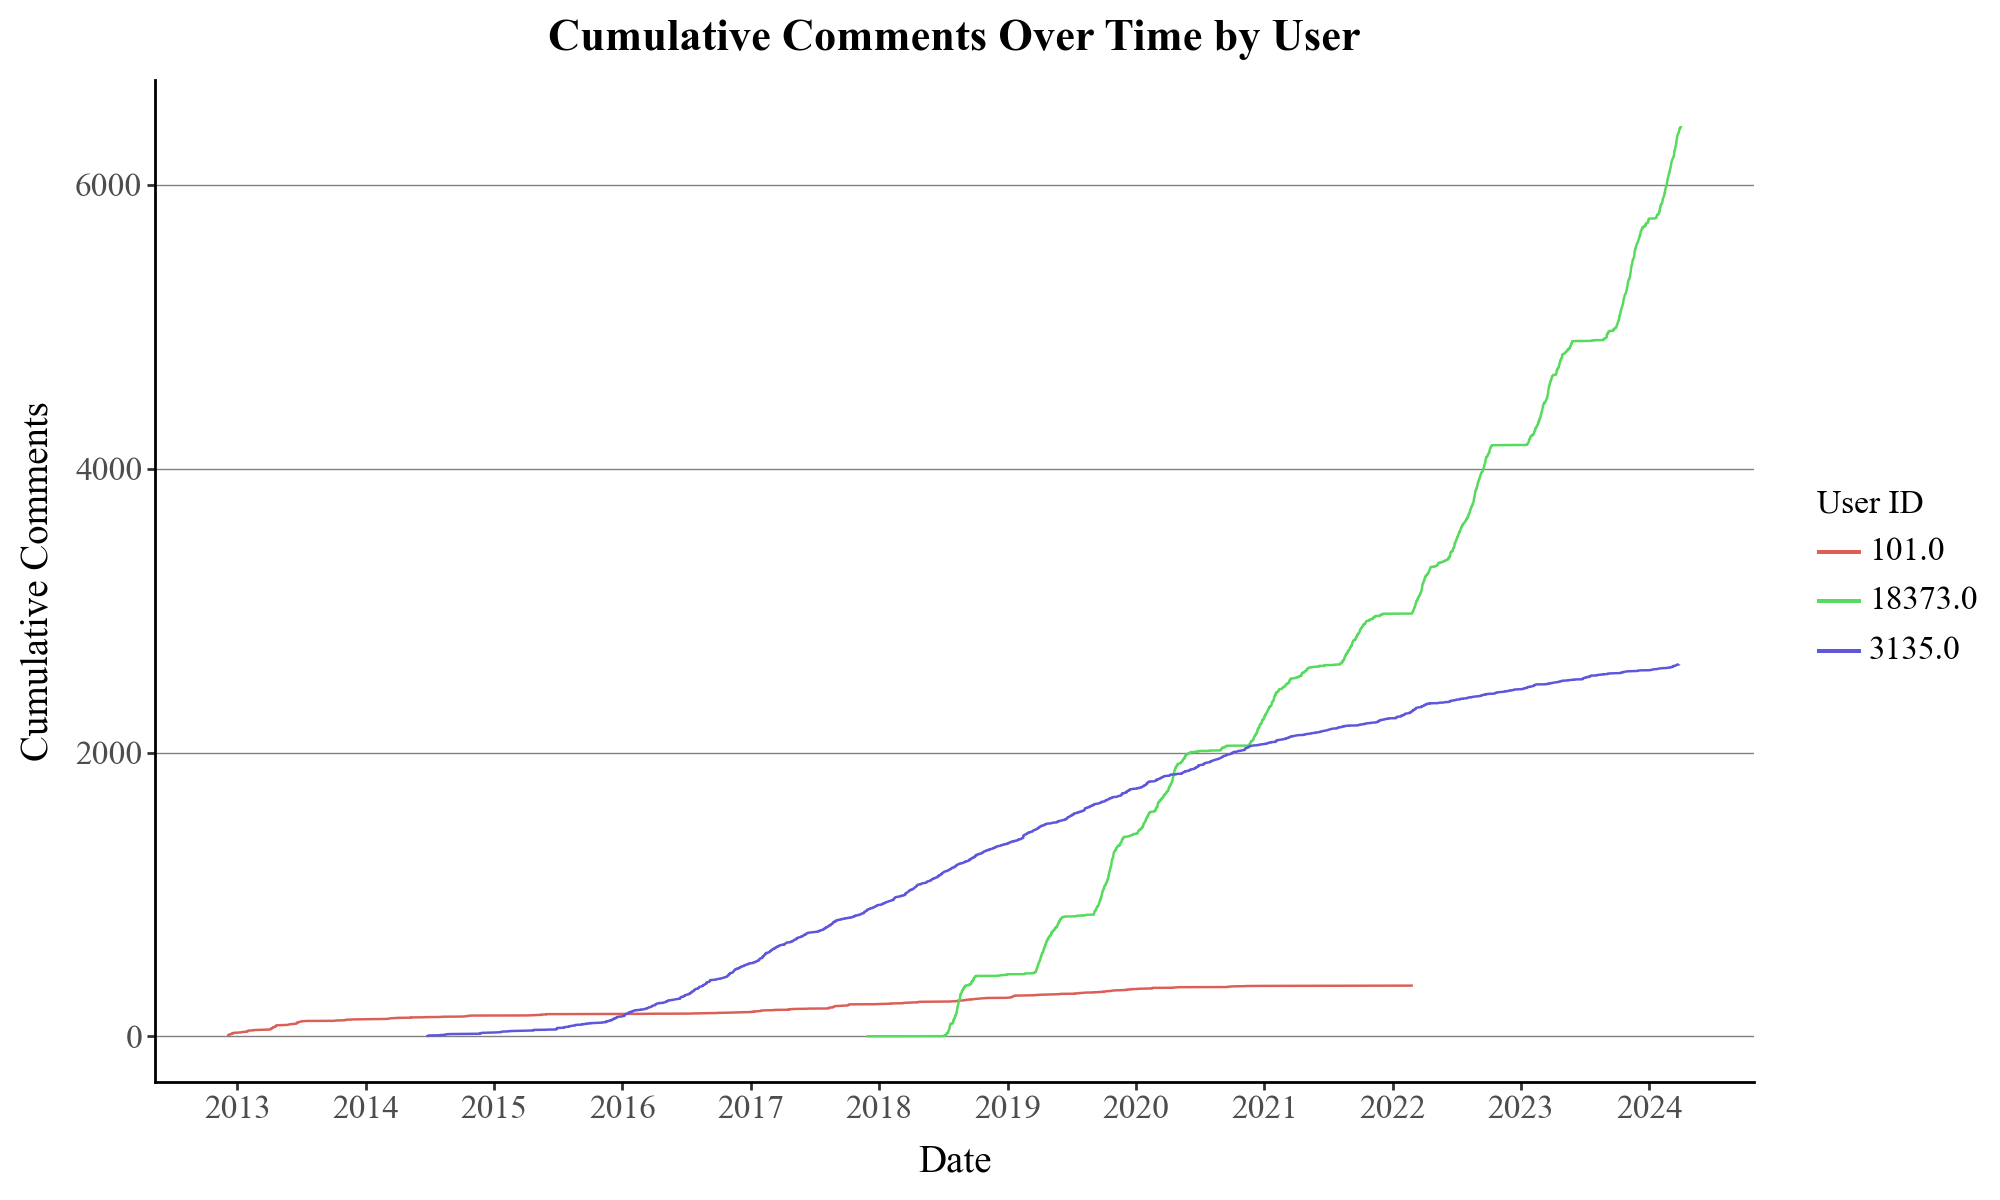

In [ ]:
from plotnine import ggplot, aes, geom_line, labs, theme_classic, theme, element_text, element_line, scale_x_datetime

# Ensure DateCreated is in datetime format
comments_relevant['CreationDate'] = pd.to_datetime(comments_relevant['CreationDate'])

# Sort the DataFrame by CreationDate
comments_relevant = comments_relevant.sort_values(by="CreationDate")

# Group by user and calculate cumulative comments
comments_relevant["CumulativeComments"] = comments_relevant.groupby("UserId").cumcount() + 1

# Create the plot using plotnine
gg = (
    ggplot(comments_relevant, aes(x="CreationDate", y="CumulativeComments", color="UserId"))
    + geom_line()
    + labs(
        title="Cumulative Comments Over Time by User",
        x="Date",
        y="Cumulative Comments",
        color="User ID"
    )
    + scale_x_datetime(date_breaks="1 year", date_labels="%Y")
    + theme_classic()
    + theme(
        text=element_text(family="Times New Roman", size=12),
        plot_title=element_text(size=16, weight='bold'),
        axis_title=element_text(size=14),
        legend_title=element_text(size=12),
        panel_grid_major_y=element_line(color="gray", size=0.5),
        figure_size=(10, 6)
    )
)

gg

## Part 1 - Understanding the subjects that polarizing users post on and comment under

- Firtly, the most common tags commented on and posted under will be derived
- All posts will then be grouped into three categories (current events, policy and ideology) with respect to their tags and a Naive Bayes classifier
- Grouping all posts will provide an overview of what each users is posting on and perphas provide insights into what makes them polarizing

**Most common tags in posts commented under**

In [19]:
# Remove all posts from posts dataset that do not contain a value in their "Id" column that isn't also in the "PostId" column of the comments dataset
posts_relevant_to_comments = posts[posts['Id'].isin(comments_relevant['PostId'])]

In [20]:
# Attach comments

# Filter `posts` DataFrame to retain relevant columns.
posts_with_comments = posts_relevant_to_comments[['Id', 'Body', 'Tags', 'OwnerUserId', 'CreationDate']]

# Group comments by `PostId` into lists for each post.
comments_grouped = comments_relevant.groupby('PostId')['Text'].apply(list).to_dict()

# Prepare a dictionary for the final structure.
final_structure = {}

for _, post_row in posts_with_comments.iterrows():
    post_id = post_row['Id']
    # Add post details (Body, Tags, OwnerUserId, CreationDate).
    column_data = [
        post_row['Body'],            # Body of the post
        post_row['Tags'],            # Tags of the post
        post_row['CreationDate'],   # CreationDate of the post
        post_row['Id']              # PostId of the post
    ]
    # Extend with comments for the post, if any exist.
    column_data.extend(comments_grouped.get(post_id, []))
    # Assign column data to the post ID.
    final_structure[post_id] = column_data

# Convert the dictionary to a DataFrame.
final_df = pd.DataFrame.from_dict(final_structure, orient='index').T

In [21]:
# Extract the list of UserIds from the 'Id' column in posts_relevant_to_comments
relevant_user_ids = posts_relevant_to_comments['Id'].unique()

# Filter the comments DataFrame for rows with UserId in the relevant_user_ids list
filtered_comments = comments[comments['PostId'].isin(relevant_user_ids)].copy()

In [25]:
# Access the row at index 1
row_data = final_df.iloc[1]

# Combine all tag strings in the row into one large string
all_tags = ""
for cell_content in row_data:
    if isinstance(cell_content, str):  # Ensure the cell contains text
        all_tags += cell_content + "|"

# Split the combined string into individual terms (case-insensitive)
tags_list = all_tags.lower().split('|')  # Split by "|" and normalize to lowercase

# Count word frequencies across all tags
word_counts = Counter(tags_list)

# Extract the 10 most common terms
most_common_terms = word_counts.most_common(11)

# Convert the result to a DataFrame
most_common_tags_comments = pd.DataFrame(most_common_terms, columns=["Word", "Count"])

# Display
print(most_common_tags_comments)

                       Word  Count
0                             5731
1             united-states    992
2        russian-federation    264
3            united-kingdom    217
4            european-union    180
5                     china    180
6                   ukraine    148
7            armed-conflict    138
8                   economy    130
9   international-relations    128
10                 election    126


**Most commmon tags in posts made**

In [26]:
# Combine all tags in the 'Tags' column into a single string
all_tags = "|".join(posts_relevant["Tags"].dropna().astype(str))

# Split the combined string into individual tags (case-insensitive)
tags_list = all_tags.lower().split('|')  # Split by "|" and normalize to lowercase

# Count tag frequencies
tag_counts = Counter(tags_list)

# 10 most common tags
most_common_tags = tag_counts.most_common(11)

# Convert the result to a DataFrame for easier analysis
most_common_tags_posts = pd.DataFrame(most_common_tags, columns=["Tag", "Count"])

# Display
print(most_common_tags_posts)

                        Tag  Count
0                             1722
1             united-states    278
2            european-union     97
3        russian-federation     93
4            united-kingdom     87
5      comparative-politics     67
6            public-opinion     56
7   international-relations     54
8                  military     53
9                  covid-19     48
10                  ukraine     44


**Subject under which they comment**

In [27]:
# COnvert all tags in the psots dataframe to strings
posts['Tags'] = posts['Tags'].astype(str)

In [28]:
# Define keywords for each category
policy_keywords = [
    'policy', 'government', 'election', 'reform', 'law', 'economics',
    'legislation', 'tax', 'budget', 'trade', 'education', 'healthcare',
    'infrastructure', 'immigration', 'energy', 'environment', 'regulation',
    'foreign-policy', 'defense', 'security', 'welfare', 'housing',
    'transportation', 'social-policy', 'public-spending', 'tariffs',
    'monetary-policy', 'fiscal-policy', 'subsidies', 'tax-reform',
    'labor-laws', 'minimum-wage', 'urban-planning', 'public-health',
    'civil-rights', 'zoning-laws', 'employment-policy', 'economic-policy',
    'military-strategy', 'climate-policy', 'environmental-policy', 'diplomacy',
    'trade-agreements', 'pensions', 'health-insurance', 'foreign-aid',
    'criminal-justice', 'legal-reform', 'gun-control', 'privacy-laws',
    'anti-corruption', 'industrial-policy', 'agriculture', 'cybersecurity',
    'transport', 'border-control', 'infrastructure-spending', 'tax-cuts',
    'income-tax', 'education-policy', 'urban-policy', 'gender-equality-laws',
    'housing-policy', 'religion', 'guns'
]

current_events_keywords = [
    'war', 'protest', 'crisis', 'ukraine', 'disaster', 'pandemic', 'election',
    'Trump', 'Biden', 'Brexit', 'Covid', 'Donald-Trump', 'hurricane',
    'climate-change', 'flood', 'drought', 'shooting', 'strike', 'scandal',
    'policy-change', 'conflict', 'treaty', 'summit', 'inflation',
    'recession', 'economic-crisis', 'migration', 'UN', 'WHO', 'NATO',
    'G7', 'referendum', 'vote', 'presidency', 'campaign', 'media-coverage',
    'terrorism', 'peace-talks', 'uprising', 'natural-disaster',
    'sports-event', 'Olympics', 'World-Cup', 'violence',
    'embassy', 'primaries', 'evacuation', 'emergency', 'border-crisis',
    'refugees', 'peace-accords', 'wildfire', 'oil-spill', 'military-coup',
    'energy-crisis', 'stock-market-crash', 'scandal', 'crime-wave',
    'congress', 'parliament', 'legislation', 'election-fraud',
    'cyberattack', 'mass-protests', 'pandemic-response', 'vaccine-rollout',
    'health-crisis', 'police-violence', 'whistleblower', 'espionage',
    'civil-unrest', 'oil-crisis', 'economic-sanctions', 'trade-war',
    'regional-conflict', 'political-prisoner', 'censorship', 'press-freedom'
]

ideology_keywords = [
    'ideology', 'philosophy', 'communism', 'belief', 'values',
    'liberal', 'conservative', 'socialism', 'capitalism', 'feminism',
    'left', 'right', 'progressive', 'reactionary', 'populism',
    'nationalism', 'globalism', 'environmentalism', 'fascism',
    'libertarianism', 'marxism', 'anarchism', 'authoritarianism',
    'individualism', 'collectivism', 'egalitarianism', 'chauvinism',
    'secularism', 'theocracy', 'pacifism', 'humanitarianism',
    'identity-politics', 'class-struggle', 'intersectionality',
    'meritocracy', 'neoliberalism', 'traditionalism', 'radicalism',
    'progressivism', 'conservatism', 'social-justice', 'patriotism',
    'federalism', 'communitarianism', 'social-constructivism',
    'anti-globalism', 'multiculturalism', 'civil-liberties', 'isolationism',
    'protectionism', 'human-rights', 'minority-rights', 'political-identity',
    'trans-nationalism', 'democratic-socialism', 'technocracy', 
    'green-politics', 'religious-fundamentalism', 'separatism',
    'equality', 'freedom', 'moral-values', 'ethics', 'public-good',
    'utilitarianism', 'elitism', 'pluralism', 'neoconservatism',
    'progressive-liberalism', 'national-sovereignty'
]


# Function to check if tags match a category
def has_category(tags, keywords):
    if pd.isna(tags):  # Handle NaN or missing values
        return False
    # Normalize tags: split by '|', strip whitespace, and convert to lowercase
    tags = [tag.strip().lower() for tag in tags.split('|') if tag.strip()]
    return any(keyword in tags for keyword in keywords)

# Apply categorization for each category
posts['Policy'] = posts['Tags'].apply(lambda tags: has_category(tags, policy_keywords))
posts['Current Events'] = posts['Tags'].apply(lambda tags: has_category(tags, current_events_keywords))
posts['Ideology'] = posts['Tags'].apply(lambda tags: has_category(tags, ideology_keywords))

In [36]:
# Function to determine the final category
def assign_category(row):
    categories = []
    if row['Policy']:
        categories.append('Policy')
    if row['Ideology']:
        categories.append('Ideology')
    if row['Current Events']:
        categories.append('Current Events')
    
    if categories:  # If there are any True values
        return random.choice(categories)  # Randomly choose one category
    else:
        return None  # If none are True, return None

# Apply the function to create the 'Category' column
posts['Category'] = posts.apply(assign_category, axis=1)

In [41]:
# Import the preprocess_text function
from utils.text_processing import preprocess_text

# Apply preprocessing to the 'Body' column
posts['Cleaned_Body'] = posts['Body'].apply(preprocess_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gianjaeger/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/gianjaeger/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gianjaeger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/gianjaeger/Desktop/Exam_fundamentals/Utils/text_processing.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.


In [42]:
# Create a new DataFrame with only the required columns
all_processed_posts = posts[['Category', 'Cleaned_Body', 'OwnerUserId', "Id"]]

In [ ]:
# Import the Naive Bayes function
from models.naive_bayes_classifier import train_and_predict_naive_bayes
from sklearn.metrics import accuracy_score

# Call the function and store the result as a dictionary
result = train_and_predict_naive_bayes(all_processed_posts)

# Extract values from the dictionary
all_posts = result["unlabeled_posts"]
classifier = result["classifier"]
vectorizer = result["vectorizer"]
y_test = result["y_test"]  # Extract y_test
y_pred_test = result["y_pred_test"]  # Extract y_pred_test

# Display accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.70


/Users/gianjaeger/Desktop/Exam_fundamentals/Models/naive_bayes_classifier.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


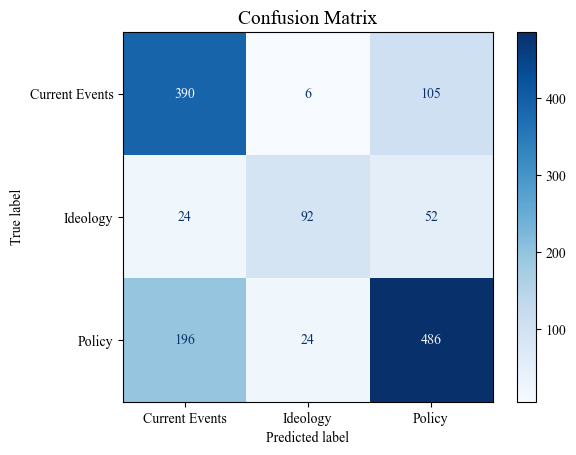

In [ ]:
# Set Times New Roman as the global font
rcParams['font.family'] = 'Times New Roman'

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot(cmap=plt.cm.Blues)

# Add title
plt.title("Confusion Matrix", fontname='Times New Roman', fontsize=14)

# Show the plot
plt.show()

In [55]:
# In the all_posts dataframe, create a new column called final_category values in the category and predicted_category columns are combined
all_posts['Final_Category'] = all_posts['Category'].fillna(all_posts['Predicted_Category'])

/var/folders/n5/_f2xjmkj39gb7s0th_6lyk9w0000gn/T/ipykernel_80823/377022031.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**What category of post do they comment under**

In [56]:
# List of specific user IDs
specific_user_ids = ['18373.0', '3135.0', '101.0']

# Ensure UserId and PostId are treated as strings
comments['UserId'] = comments['UserId'].astype(str)
comments['PostId'] = comments['PostId'].astype(str)

# Filter only rows where UserId matches the specified user IDs
filtered_comments = comments[comments['UserId'].isin(specific_user_ids)]

# Group by PostId and UserId, count the number of comments
grouped_comments = filtered_comments.groupby(['PostId', 'UserId']).size().reset_index(name='Number_of_Comments')

# Pivot to create columns for each user and fill missing values with 0
pivot_table = grouped_comments.pivot(index='PostId', columns='UserId', values='Number_of_Comments').fillna(0)

# Filter the pivot table to include only rows where at least one user commented
pivot_table = pivot_table.loc[pivot_table.sum(axis=1) > 0]

# Ensure columns are in the correct order and reset the index
result_df = pivot_table[specific_user_ids].reset_index()

# Rename columns for clarity
result_df.columns = ['PostId'] + [f'Comments_by_User_{user}' for user in specific_user_ids]

In [57]:
# Merge results_df with all_posts to bring the Category column
merged_df = result_df.merge(all_posts[['Id', 'Final_Category']], 
                             left_on='PostId', 
                             right_on='Id', 
                             how='left')

# Drop the redundant 'Id' column from all_posts if not needed
merged_df = merged_df.drop(columns=['Id'])

In [58]:
# Dynamically match the user comment columns based on a common pattern
user_columns = [col for col in merged_df.columns if 'Comments_by_User' in col]

# Group by 'Final_Category' and calculate the sum of comments per user in each category
category_totals = merged_df.groupby('Final_Category')[user_columns].sum()

# Calculate the total number of comments for each user across all categories
user_totals = category_totals.sum(axis=0)

# Calculate the percentage of comments per category for each user
category_percentages = (category_totals / user_totals) * 100

# Display the results
print(category_percentages)

                Comments_by_User_18373.0  Comments_by_User_3135.0  \
Final_Category                                                      
Current Events                 50.656518                35.266160   
Ideology                        6.298763                10.788973   
Policy                         43.044719                53.944867   

                Comments_by_User_101.0  
Final_Category                          
Current Events               37.857143  
Ideology                      8.571429  
Policy                       53.571429  


**What categories do they post under**

In [59]:
# Convert OwnerUserId column in the all_posts dataframe to string
all_posts['OwnerUserId'] = all_posts['OwnerUserId'].astype(str)

/var/folders/n5/_f2xjmkj39gb7s0th_6lyk9w0000gn/T/ipykernel_80823/133807191.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [60]:
# Merge final_category column from all_posts dataframe onto the relevant posts dataframe
posts_relevant = posts_relevant.merge(all_posts[['Id', 'Final_Category']], left_on='Id', right_on='Id', how='left')

In [61]:
# Calculate the counts of each OwnerUserId-Category combination
counts = posts_relevant.groupby(['OwnerUserId', 'Final_Category']).size().reset_index(name='Count')

# Calculate the total posts for each OwnerUserId
total_counts = posts_relevant.groupby('OwnerUserId').size().reset_index(name='Total')

# Merge the counts with total counts
merged = counts.merge(total_counts, on='OwnerUserId')

# Calculate the percentage
merged['Percentage'] = (merged['Count'] / merged['Total']) * 100

# Reshape the DataFrame to show both counts and percentages per category
result = merged.pivot(index='OwnerUserId', columns='Final_Category', values=['Count', 'Percentage']).fillna(0)

# Display the result
print(result)

                        Count                      Percentage            \
Final_Category Current Events Ideology  Policy Current Events  Ideology   
OwnerUserId                                                               
101.0                    26.0      6.0    32.0      36.111111  8.333333   
18373.0                1019.0    112.0  1006.0      40.533015  4.455052   
3135.0                  177.0     48.0   289.0      34.302326  9.302326   

                           
Final_Category     Policy  
OwnerUserId                
101.0           44.444444  
18373.0         40.015911  
3135.0          56.007752  


## Part 2: k-means clustering

python(3435) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


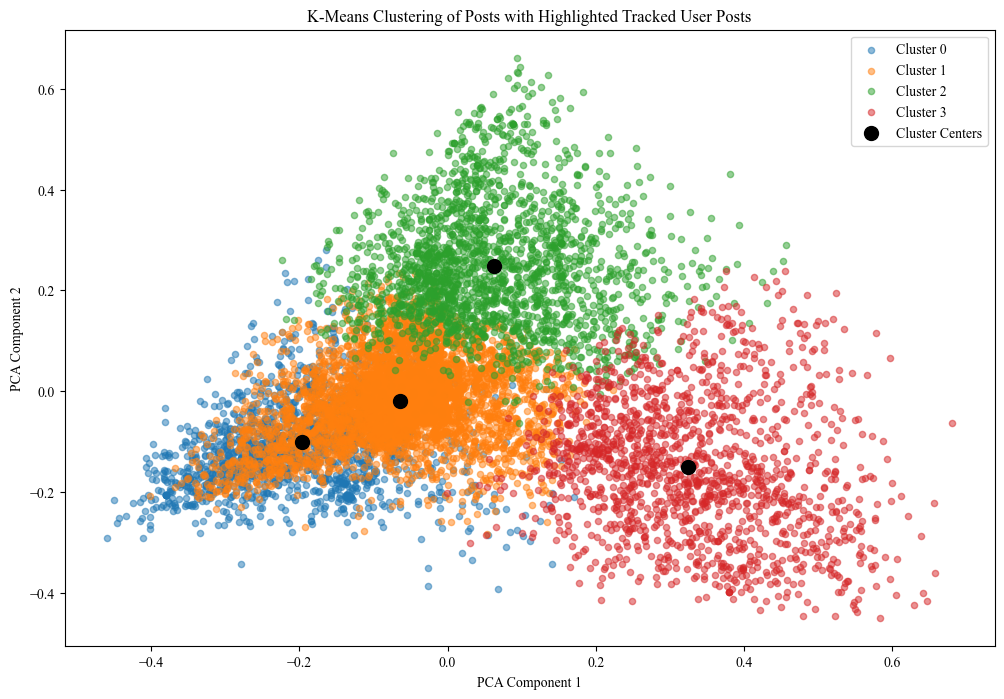

In [62]:
from models.kmeans_clustering import cluster_posts_with_pca

# Define tracked users
tracked_users = ['101.0', '18373.0', '3135.0']

# Call the clustering function
results = cluster_posts_with_pca(all_posts, tracked_users)

# Extract results
all_posts = results["all_posts"]
reduced_centers = results["reduced_centers"]
non_tracked_data = results["non_tracked_data"]
tracked_data = results["tracked_data"]

# Visualization
plt.figure(figsize=(12, 8))

# Plot non-tracked posts by cluster
for cluster in range(4):
    cluster_data = non_tracked_data[non_tracked_data['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], 
                label=f"Cluster {cluster}", alpha=0.5, s=20)  # Small dots for non-tracked posts

#(UNCOMMENT THIS TO MARK RELEVANT USERS' POSTS)
# Highlight tracked posts with larger red 'X' 
#plt.scatter(tracked_data['PCA1'], tracked_data['PCA2'], 
#            color='red', marker='x', s=300, label="Tracked User Posts")  # Large and distinct

# Add cluster centers
plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], 
            color='black', marker='o', s=100, label='Cluster Centers')

# Add labels and legend
plt.title("K-Means Clustering of Posts with Highlighted Tracked User Posts")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [57]:
# Most frequent words per cluster (to understand the "topic" each cluster roughly represents)

# Group posts by cluster
cluster_texts = all_posts.groupby('Cluster')['Cleaned_Body'].apply(lambda x: ' '.join(x))

# Extract keywords using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=10)  # Top 10 words per cluster
keywords = {}

for cluster, text in cluster_texts.items():
    tfidf_matrix = vectorizer.fit_transform([text])
    feature_names = vectorizer.get_feature_names_out()
    keywords[cluster] = feature_names

# Display keywords for each cluster
for cluster, words in keywords.items():
    print(f"Cluster {cluster}: {', '.join(words)}")

Cluster 0: china, country, government, military, people, russia, russian, state, ukraine, war
Cluster 1: congress, election, house, law, office, power, president, senate, state, trump
Cluster 2: country, government, law, like, people, political, question, right, state, time
Cluster 3: candidate, election, party, people, political, republican, state, vote, voter, voting


## Part 3: Cosine distance

**Cosine Similarity for Comment Content**
Objective:
Compare the content of comments made by the three users to see if their language or focus aligns.

Steps:
Preprocess Text:
Tokenize, remove stop words, and vectorize comments using TF-IDF.
Compute Cosine Similarity:
Measure similarity between users’ comment vectors.
Insights:
Users with high similarity may focus on similar themes or topics.
Identify differences in their tone or areas of interest.

In [64]:
# Define the tracked users
tracked_users = ['101', '18373', '3135']

# Filter out comments from tracked users to get the control group
control_comments = comments_relevant[~comments_relevant['UserId'].isin(tracked_users)]

# Sample 1000 random comments for the control group
control_sample = control_comments.sample(n=1000, random_state=42).copy()

# Assign a placeholder 'UserId' for the control group
control_sample['UserId'] = 'control'

# Append the control group to the existing tracked users' comments
updated_comments = pd.concat([comments_relevant, control_sample], ignore_index=True)

In [65]:
updated_comments['Cleaned_Body'] = updated_comments['Text'].apply(preprocess_text)

/Users/gianjaeger/Desktop/Exam_fundamentals/Utils/text_processing.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
/Users/gianjaeger/Desktop/Exam_fundamentals/Utils/text_processing.py:19: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.


In [66]:
# Group comments by UserId, concatenating all comments into a single text block
user_texts = updated_comments.groupby('UserId')['Text'].apply(lambda x: ' '.join(x)).reset_index()

In [67]:
# Group comments by UserId, concatenating all comments into a single text block
user_texts = updated_comments.groupby('UserId')['Text'].apply(lambda x: ' '.join(x)).reset_index()

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)

# Fit and transform the comments
tfidf_matrix = vectorizer.fit_transform(user_texts['Text'])

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Convert to a DataFrame for readability
cosine_df = pd.DataFrame(cosine_sim, index=user_texts['UserId'], columns=user_texts['UserId'])

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Convert to a DataFrame for readability
cosine_df = pd.DataFrame(cosine_sim, index=user_texts['UserId'], columns=user_texts['UserId'])

<Figure size 800x600 with 0 Axes>

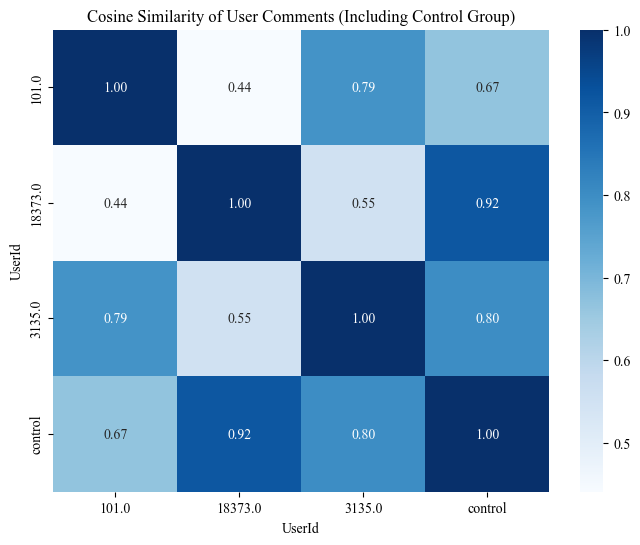

In [73]:
# Plot the updated cosine similarity heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cosine_df, annot=True, cmap='Blues', fmt=".2f")
plt.title("Cosine Similarity of User Comments (Including Control Group)")
plt.show()